In [1]:
import os
from PIL import Image
import itertools

import cv2
import numpy as np 
import pandas as pd 
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout,BatchNormalization

import warnings
warnings.filterwarnings('ignore')

print('Modules Successfully Loaded')

/Users/nguyen.vo.int/Downloads/brain-tumor-classification-main/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Modules Successfully Loaded


In [2]:
root_path = os.path.dirname(os.getcwd())
data_dir = os.path.join(root_path, "brain_tumor_44_classes")

In [3]:
paths = []
labels = []
folds = os.listdir(data_dir)

for fold in folds:
    condition_path = os.path.join(data_dir, fold)
    
    # Check if the path is a directory
    if os.path.isdir(condition_path):
        all_pic = os.listdir(condition_path)
        for each_pic in all_pic:
            each_pic_path = os.path.join(condition_path, each_pic)
            # Check if it's a file and not a hidden system file
            if os.path.isfile(each_pic_path) and not each_pic.startswith('.'):
                paths.append(each_pic_path)
                labels.append(fold.split(' ')[0])

pseries = pd.Series(paths, name='Picture Path')
lseries = pd.Series(labels, name='Label')

df = pd.concat([pseries, lseries], axis=1)
df

,Picture Path,Label
0,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Granuloma
1,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Granuloma
2,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Granuloma
3,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Granuloma
4,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Granuloma
...,...,...
4474,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Meningioma
4475,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Meningioma
4476,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Meningioma
4477,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Meningioma


In [4]:
train_df, ts_df = train_test_split(df,test_size= 0.2,shuffle=True,random_state=42,stratify= df['Label'])
test_df, valid_df = train_test_split(ts_df,test_size= 0.5,shuffle=True,random_state=42,
                                          stratify= ts_df['Label'])

In [5]:
train_df

,Picture Path,Label
902,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Tuberculoma
1600,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Meduloblastoma
32,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Astrocitoma
971,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Carcinoma
3806,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Neurocitoma
...,...,...
1713,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Oligodendroglioma
3468,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Ependimoma
673,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Neurocitoma
3431,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Ependimoma


In [6]:
test_df

,Picture Path,Label
1254,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,_NORMAL
3400,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Meduloblastoma
3340,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,_NORMAL
3575,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Astrocitoma
2102,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Astrocitoma
...,...,...
3642,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Astrocitoma
3408,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Meduloblastoma
2560,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Schwannoma
824,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Tuberculoma


In [7]:
valid_df

,Picture Path,Label
3067,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Schwannoma
4271,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Meningioma
4029,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Oligodendroglioma
1981,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Meningioma
4253,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Meningioma
...,...,...
3989,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Neurocitoma
762,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Papiloma
3751,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Astrocitoma
2961,/Users/nguyen.vo.int/Downloads/brain-tumor-cla...,Schwannoma


In [8]:
batch_size = 32
img_size = (224,224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='Picture Path', y_col='Label',target_size= img_size, 
                                   class_mode= 'categorical', color_mode='rgb', shuffle = True,
                                   batch_size= batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='Picture Path', y_col='Label',target_size= img_size, 
                                   class_mode= 'categorical', color_mode='rgb', shuffle = True,
                                   batch_size= batch_size)

test_gen = gen.flow_from_dataframe(test_df, x_col='Picture Path', y_col='Label',target_size= img_size, 
                                   class_mode= 'categorical', color_mode='rgb', shuffle = False,
                                   batch_size= batch_size)

Found 3583 validated image filenames belonging to 15 classes.
Found 448 validated image filenames belonging to 15 classes.
Found 447 validated image filenames belonging to 15 classes.


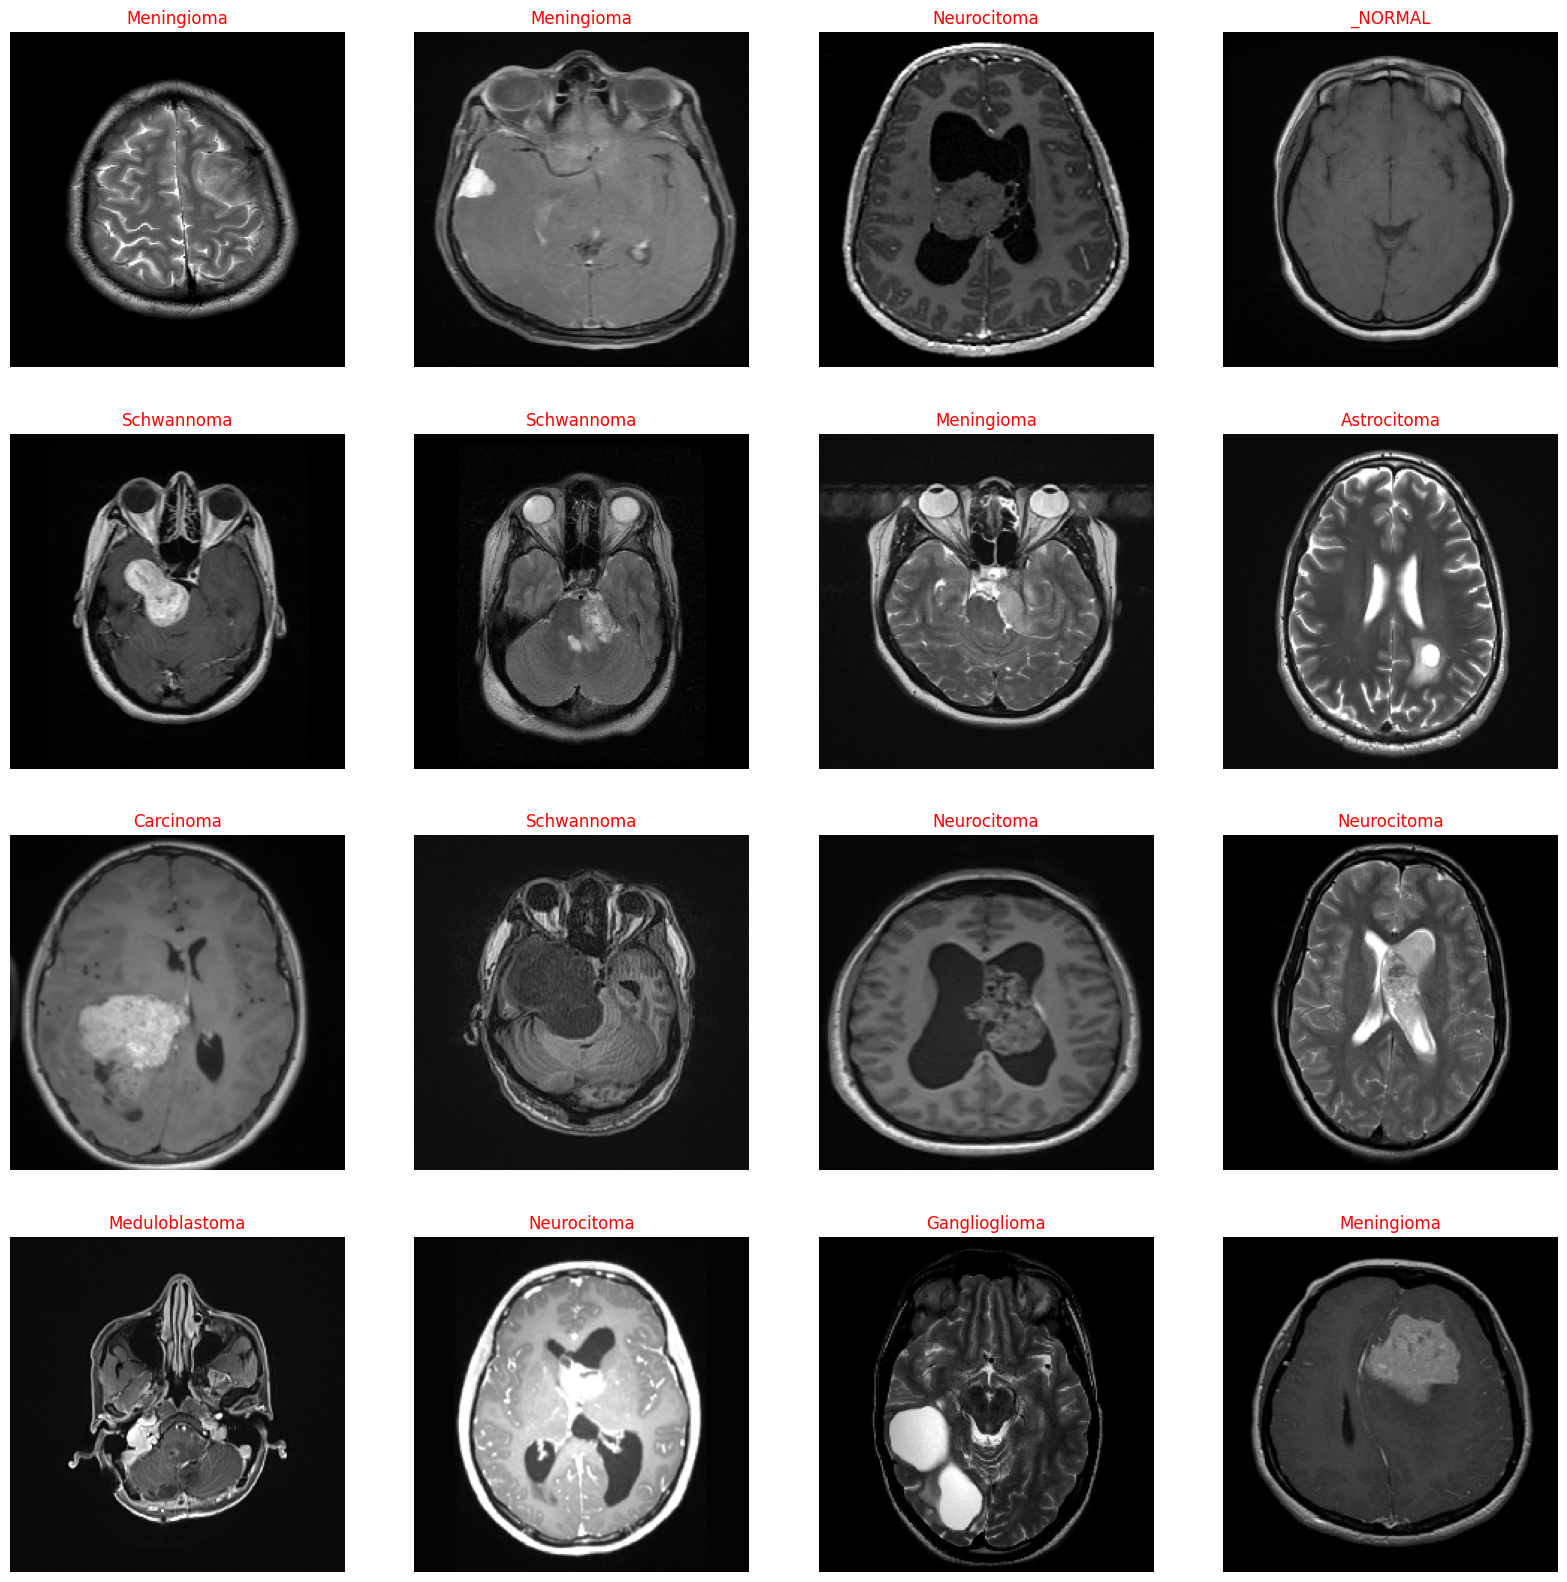

In [9]:
g_dict = train_gen.class_indices
classes= list(g_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range (16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index= np.argmax(labels[i]) #[0,0,0,1,0]
    class_name = classes[index]
    plt.title(class_name,c='r', fontsize=12)
    plt.axis('off')
plt.show()

In [10]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )

base_model = tf.keras.applications.DenseNet169(include_top= False , weights= "imagenet", 
                                                               input_shape= img_shape, pooling= 'max')
# include_top is false because we wanna do fine tunnig on the model(we will only use a part of it then
# use our ann layers)
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    # too many dense layers because we will use dropout in the next line
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', 
              metrics= ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                        tf.keras.metrics.AUC()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)        │ (None, 1664)           │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1664)           │         6,656 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       426,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,079,631 (49.89 MB)

 Trainable params: 12,917,903 (49.28 MB)

 Non-trainable params: 161,728 (631.75 KB)

In [ ]:
hist= model.fit(train_gen, epochs= 15, verbose= 1, validation_data= valid_gen, shuffle= False )